# Qiskit & IBM Quantum Workshop



This tutorial was adapted from notebooks by: _Abby Mitchell - Quantum Developer Advocate (https://abbymitchell.dev) IBM Quantum_ and from _Kevin Sung - Qiskit Researcher, IBM Quantum_

# Goal: Show you the toolbox - Breadth, not depth!



# Qiskit 102: Learning to use Qiskit

The fundamental unit you will primarily work with in Qiskit is the `QuantumCircuit` object. The basic workflow to using Qiskit consists of two stages: build and execute. Building involves making different quantum circuits which represent the problem/algorithm you are solving. Executing takes care of the, well, *execution* of those circuits as a job or set of jobs to be run on either real or simulated hardware. After the jobs have been run, the data is collected and must be postprocessed depending on the desired output.  We can do most of this post-processing using Qiskit Runtime.

## Qiskit Runtime 

Qiskit Runtime is a cloud-based quantum computing service developed by IBM. It offers computational primitives to perform foundational quantum computing tasks that use built-in error suppression and mitigation techniques. Primitives can be executed inside of sessions, allowing collections of circuits to be jointly run on a quantum computer without being interrupted by other users’ jobs. The combination of primitives, error suppression / mitigation, and sessions paves the way to efficiently build and execute scalable quantum applications.


---

## Getting Started

The Qiskit packages you will need to get started are:

- `qiskit`
- `qiskit-ibm-runtime`
- `numpy` (optional)
- `matplotlib` (optional)

We'll first walk through the anatomy of a `QuantumCircuit` object and the process of using primitives.


In [ ]:
%pip install qiskit[visualization] # this line will install qiskit and extra visualization packages
%pip install qiskit-aer
%pip install qiskit-ibm-runtime
%pip install qiskit-ibm-transpiler
# %pip install qiskit-ibm-catalog
# %pip install qiskit-addon-utils
# %pip install qiskit-serverless
# %pip install qiskit-addon-sqd
# %pip install qiskit-addon-obp

### Key concepts

**Primitives**

Primitives are base level operations that serve as building blocks for many quantum algorithms and applications. Through these primitives, users can obtain high-fidelity results, without needing detailed hardware knowledge.  This abstraction allows you to write code, using Qiskit algorithms or otherwise, that can run on different quantum hardware or simulators without having to explicitly manage aspects such as compilation, optimization, and error suppression / mitigation. The primitives offered by `qiskit_ibm_runtime <https://qiskit.org/ecosystem/ibm-runtime/apidocs/ibm-runtime.html>`__ add additional options specific to IBM services. See `Introduction to primitives <primitives.html>`__ for further details.

There are currently two primitives defined in Qiskit: Estimator and Sampler.


**Estimator**

The estimator primitive allows you to efficiently calculate and interpret expectation values of quantum operators; the values of interest for many near-term quantum algorithms. You specify circuits that prepare quantum states and then Pauli-basis observables to measure on those states. The estimator can use advanced error suppression and mitigation capabilities to improve the accuracy of the returned expectation values.

**Sampler**

This primitive takes circuits as input and returns a quasi-probability distribution over the measurement outcomes. This generalizes histograms from quantum circuits, allowing for mitigation of readout errors.

**Error suppression / mitigation**

While building a fault-tolerant quantum computation is the ultimate goal, at present, calculations performed on near-term quantum computers are susceptible to noise.  Qiskit Runtime offers a number of methods for preventing errors before they occur (error suppression techniques) and dealing with those that do occur (error mitigation techniques).  


# Time for some code! (finally!)

## Simple Examples:

## 0.1 Building the circuit 

The basic element needed for your first program is the QuantumCircuit. We begin by creating a QuantumCircuit comprised of two qubits.

In [1]:
from qiskit import QuantumCircuit

# Create a Quantum Circuit acting on a quantum register of two qubits
circ = QuantumCircuit(2)
print(circ)

     
q_0: 
     
q_1: 
     


## 0.2 Adding Gates

We can then add gates to the circuit. We start with a Hadamard gate acting on qubit $0$ and then add a $C_X$ (CNOT) gate using $0$ as the control qubit and $1$ as the target. 

In [2]:
# Add a H gate on qubit 0, putting this qubit in superposition.
circ.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.
circ.cx(0, 1)

## 0.3 Circuit Visualization

You can visualize your circuit using the `QuantumCircuit.draw()` method, which plots the circuit in the form found in many textbooks.

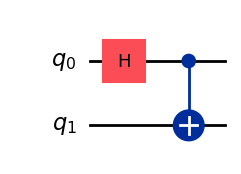

In [3]:
circ.draw('mpl', style="iqp")

In [4]:
#One can also draw this as an ascii drawing
circ.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘


A few of the basic gates which can be added to a quantum circuit are the:

* Pauli $X$, $Y$, $Z$ gates - `.x()` `.y()`
* Hadamard $H$ gate 
* $S$ (or $\pi/2$) phase gate
* $T$ (or $\pi/4$) phase gate
* Controlled-NOT (or Controlled-$X$) gate - `.cx`
* Controlled-$H$ gate - `.ch`
* CCX or Toffoli gate - `.ccx`

among many others.  See the documentation for the full list of supported gates.

# 1.0 Using Primitives

There are two main approaches within Qiskit to execute and measure your quantum circuits called `Primitives`.  The first is the `Estimator` which computes the expectation values of observables.  Users generally specify a list of circuits, observables, and a few other optional configurations, with which the program can efficiently evaluate expectation values and variances.  The second is the `Sampler` primitive which with calculate the probabilities (or quasi-probabilities if using error mitigation) of bitstrings from quantum circuits.

Primitives work most effectively when they are supported by both Qiskit and the backend provider. The Qiskit module qiskit.primitives provides the required support on the Qiskit side, and providers like IBM Qiskit Runtime enable access to appropriate backends through native implementations of their own primitives.

We'll learn to use these objects by utilizing a small example circuit which will fully entangle two qubits together and then measure them.

 we'll demonstrate using the `Sampler` primitive (both the `qiskit.primitives` version as well as the managed `qiskit-ibm-runtime` version).  Recall the `Sampler` is primarily useful for when you want to measure (quasi-)probability distributions.  We'll use the same quantum circuit, `qc` which prepares a Bell state (i.e., fully entangle two-qubits together).


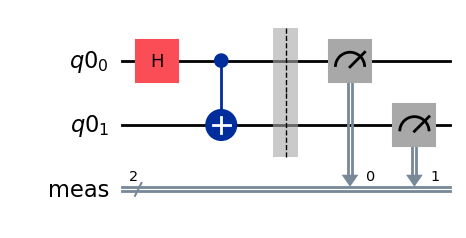

In [5]:
from qiskit import QuantumCircuit, QuantumRegister
# Initialize the qubits
qubits = QuantumRegister(2)

# Create the circuit
circuit = QuantumCircuit(qubits)

# Unpack the qubits
q0, q1 = qubits

# Add the Hadamard and CNOT gates to the circuit
circuit.h(q0)
circuit.cx(q0, q1)

# Measure both qubits
circuit.measure_all()
circuit.draw("mpl")

Now we'll simulate this circuit using the reference Sampler primitive.

Job Result:
>>> PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'shots': 1024, 'circuit_metadata': {}})], metadata={'version': 2})
 > Metadata: {'version': 2}
{'00': 541, '11': 483}


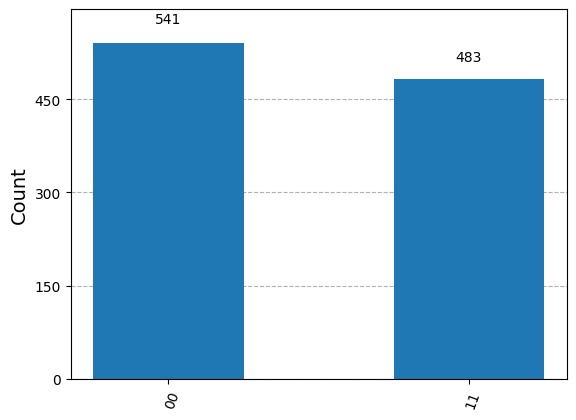

In [6]:
from qiskit_ibm_runtime import Sampler
from qiskit_aer import AerSimulator

sim = AerSimulator()
sampler = Sampler(mode=sim)

# Now run the job and examine the results
sampler_job = sampler.run([circuit])
result = sampler_job.result()
print(f"Job Result:\n>>> {result}")

print(f" > Metadata: {result.metadata}")

# Print the results
counts = result[0].data.meas.get_counts()
print(counts)

# import basic plot tools
from qiskit.visualization import plot_histogram
plot_histogram(counts)

Next we'll use the Runtime Sampler to run our circuit on a backend.  Recall that we still need to specify an `IBMBackend` object through the `QisktRuntimeService` and ensure the circuit is written in terms of the backend's ISA.

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService

################# MAKE SURE YOUR API TOKEN IS SAVED ##########################

# Store your API token locally (only need to do once)
# QiskitRuntimeService.save_account(channel='ibm_quantum', token='$API_TOKEN')

##############################################################################

# Initialize a QiskitRuntimeService object
service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")

# Print the available backends
print("Available backends:")
for backend in service.backends():
    print(backend.name)

Available backends:
ibm_brisbane
ibm_sherbrooke
ibm_kyiv


In [ ]:
print(service.instances())
print(service.active_account())
print(service.saved_accounts())

For this example we'll use the 127-qubit `ibm_brisbane` backend.  You can obtain information about its status, the number of pending jobs, and detailed configuration information.

In [11]:
backend = service.backend("ibm_brisbane")

# Here we can get some status information about the backend
status = backend.status()
is_operational = status.operational
jobs_in_queue = status.pending_jobs
print("Operational?: {} \n Jobs in Queue: {}\n".format(is_operational, jobs_in_queue))

# We can also obtain some configuration information
config = backend.configuration()
print(
    64 * "#",
    "\nConfiguration for: {}, version: {}".format(
        config.backend_name, config.backend_version
    ),
)
print("  Number of Qubits: {}".format(config.n_qubits))
print("  Basis Gates: {}".format(config.basis_gates))
print("  OpenPulse Enabled: {}".format(config.open_pulse))

Operational?: True 
 Jobs in Queue: 42

################################################################ 
Configuration for: ibm_brisbane, version: 1.1.74
  Number of Qubits: 127
  Basis Gates: ['ecr', 'id', 'rz', 'sx', 'x']
  OpenPulse Enabled: True


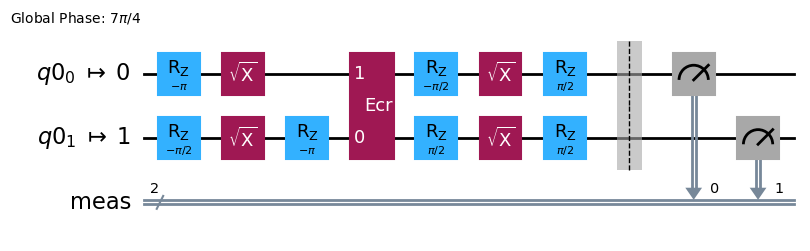

In [12]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Create a staged pass manager which will translate the circuit in terms of the basis gates of the backend
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
transpiled_circuit = pm.run(circuit)

transpiled_circuit.draw('mpl', idle_wires=False)


In [13]:
# This import overwrites our previous Sampler import
from qiskit_ibm_runtime import Sampler

# Use a runtime session to reduce time spent waiting in the queue

sampler = Sampler(mode=backend)
job = sampler.run([(transpiled_circuit)])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cynx8d9r32sg0089ytmg
>>> Job Status: QUEUED


We can also obtain a previous result in the same way as the `Estimator`.

In [20]:
# Use a job id from a previous result
job = service.job("cynx8d9r32sg0089ytmg")
print(f">>> Job Status: {job.status()}")

>>> Job Status: QUEUED


For the sampler primitive, the `PrimitiveResult` we get back has `PubResults` containing the raw count data obtained over all shots.  The `get_counts()` function will return 

In [32]:
result = job.result()
print(f"Job Result:\n>>> {result}")
print(f"  > Quasi-probability distribution (integer): {result[0].data.meas.get_counts()}")
print(f"  > Metadata: {result.metadata}")


Job Result:
>>> PrimitiveResult([PubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'version': 2})
  > Quasi-probability distribution (integer): {'11': 1977, '00': 1890, '10': 100, '01': 129}
  > Metadata: {'version': 2}


We can also obtain a previous result in the same way as the `Estimator`.

In [115]:
# Use a job id from a previous result
job = service.job("cnxwrpjmbjng0081zhc0")
print(f">>> Job Status: {job.status()}")

>>> Job Status: JobStatus.DONE


We're also able to visualize the probability distribution of this circuit on a histogram.  Plotting this gives us a quick visual tool to help us understand what the states with the highest measurement probability are. 

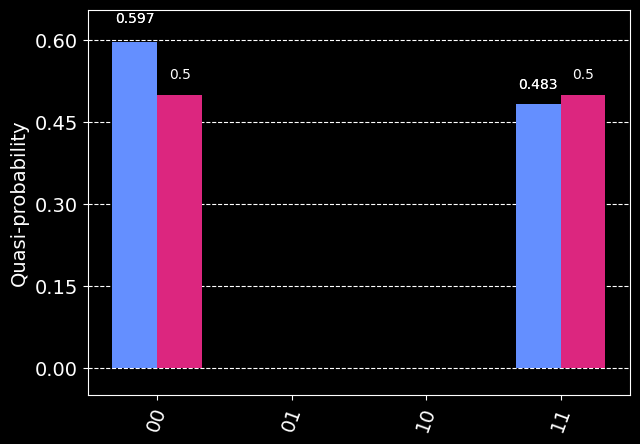

In [118]:
# from qiskit.visualization import plot_distribution

# import matplotlib.pyplot as plt
# plt.style.use('dark_background')

# #plot_distribution(result.quasi_dists[0])
# plot_distribution([result.quasi_dists[0].binary_probabilities(2),prob_distribution])

## 1.1 The Estimator Primitive

Let's begin with understanding how to use the `Estimator` primitive.  To start, we'll need to define the observable(s) we want to measure the expectation values of.  They can be constructed from any `BaseOperator` object, like the operators from `qiskit.quantum_info`.  For this example we'll use the `qiskit.quantum_info.SparesPauliOp` object.  We'll construct four observables to measure our entangling circuit, $\langle II +XX -YY + ZZ\rangle$.

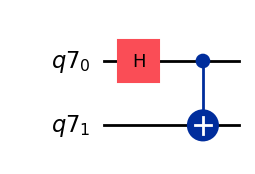

In [16]:
from qiskit import QuantumCircuit, QuantumRegister

# Initialize the qubits
qubits = QuantumRegister(2)

# Create the circuit
circuit = QuantumCircuit(qubits)

# Unpack the qubits
q0, q1 = qubits

# Add the Hadamard and CNOT gates to the circuit
circuit.h(q0)
circuit.cx(q0, q1)

circuit.draw("mpl")

In [17]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])

Once the observable and `Estimator` object are defined, we can go ahead and run our estimation by calling the `qiskit.primitives.Estimator.run()` method.

Let's measure this observable using the reference Estimator primitive using the simulation package, `qiskit-aer`.

In [18]:
from qiskit_ibm_runtime import Estimator
from qiskit_aer import AerSimulator

# Define backend
sim = AerSimulator()
estimator = Estimator(mode=sim)

job = estimator.run([(circuit, observable)])
result = job.result()
print(result)
print(f"Expectation Value of <II+XX-YY+ZZ> = {result[0].data.evs:.3f}")

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=0.0), metadata={'target_precision': 0.015625, 'shots': 4096, 'circuit_metadata': {}})], metadata={'version': 2})
Expectation Value of <II+XX-YY+ZZ> = 4.000


We'll now execute this circuit on real hardware using a Runtime primitive.  To do so, we'll need to initialize a `QiskitRuntimeService` object and select a backend to run the circuit on.  The access your institution has obtained will determine which backends are available to you.

In [21]:
from qiskit_ibm_runtime import QiskitRuntimeService

################# MAKE SURE YOUR API TOKEN IS SAVED ##########################

# Store your API token locally (only need to do once)
# QiskitRuntimeService.save_account(channel='ibm_quantum', token='$API_TOKEN')

##############################################################################

# Initialize a QiskitRuntimeService object
# service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")
service = QiskitRuntimeService(channel="ibm_quantum")

# Print the available backends
print("Available backends:")
for backend in service.backends():
    print(backend.name)

Available backends:
ibm_brisbane
ibm_cusco
ibm_kyiv
ibm_nazca
ibm_sherbrooke
ibm_torino
ibmq_lima
test_eagle_us-east


In [ ]:
print(service.instances())
print(service.active_account())
print(service.saved_accounts())

For this example we'll use the 127-qubit `ibm_brisbane` backend.  You can obtain information about its status, the number of pending jobs, and detailed configuration information.

In [27]:
backend = service.backend("ibm_kyiv")

# Here we can get some status information about the backend
status = backend.status()
is_operational = status.operational
jobs_in_queue = status.pending_jobs
print("Operational?: {} \n Jobs in Queue: {}\n".format(is_operational, jobs_in_queue))

# We can also obtain some configuration information
config = backend.configuration()
print(
    64 * "#",
    "\nConfiguration for: {}, version: {}".format(
        config.backend_name, config.backend_version
    ),
)
print("  Number of Qubits: {}".format(config.n_qubits))
print("  Basis Gates: {}".format(config.basis_gates))
print("  OpenPulse Enabled: {}".format(config.open_pulse))

Operational?: True 
 Jobs in Queue: 3

################################################################ 
Configuration for: ibm_kyiv, version: 1.20.22
  Number of Qubits: 127
  Basis Gates: ['ecr', 'id', 'rz', 'sx', 'x']
  OpenPulse Enabled: True


Now we'll run our job on hardware.  However first we must ensure that this circuit is written in terms of the *Instruction Set Architecture* (ISA) of the backend.  This essentially means the circuit must be written in terms of the available basis gates of the backend we will submit to.

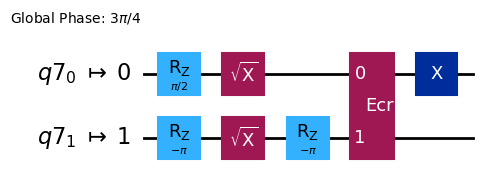

In [28]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Create a staged pass manager which will translate the circuit in terms of the basis gates of the backend
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
transpiled_circuit = pm.run(circuit)

transpiled_circuit.draw('mpl', idle_wires=False)


We also have to ensure that the observable respects the layout of the circuit (i.e. the arrangement of hardware qubits we'll use).  This can be done using the `apply_layout()` method.

In [29]:
# Get the qubit layout from the transpiled circuit
layout = transpiled_circuit.layout

# Ensure the observables are formatted to respect this layout.  This will insert Identity gates on qubits where no expectation value is specified
observables = observable.apply_layout(layout)
# observables = [ [observable.apply_layout(layout) for observable in observable_set] for observable_set in observable   ]
print(observables)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYY', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j])


The `Estimator` primitive takes its input in the form of a list of tuples containing a circuit, observables, and (optionally) parameters.  Each tuple is called as *Primitive Unitary Bloc* (PUB) and allows you to sweep across observables, parameters, and circuits in an efficient, vectorized way. 

In [30]:
# This import overwrites our previous Estimator import
from qiskit_ibm_runtime import Estimator

# Use a runtime session to reduce time spent waiting in the queue
estimator = Estimator(mode=backend)
job = estimator.run([(transpiled_circuit, observables )])

print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cynxapj1j2e0008kmw5g
>>> Job Status: QUEUED


We can also check on the status on the online platform: [https://quantum.ibm.com/jobs](https://quantum.ibm.com/jobs)

Another useful feature is to be able to pull data from previous jobs you've run if you're running analysis on your results in a separate notebook or python script.  All that's needed is the Job ID

In [40]:
# Use a job id from a previous result
job = service.job("cynxapj1j2e0008kmw5g") # You'll change this to your particular Job ID you'd like to examine
print(f">>> Job Status: {job.status()}")

>>> Job Status: DONE


The results are returned in the form of a `PrimitiveResult` object, which contains a list of `PubResults` for each of the individual tuples (i.e. PUBs) used when `estimator.run()` was called.  Each `PubResult` can be accessed by its index and contains information about the expectation values, standard deviation, and standard error.

In [41]:
# Examine our results once the job has completed
result = job.result()
print(f">>> {result} \n \n", 32*"#", "\n")
print(f" >>  Expectation values:\n {result[0].data.evs} \n\n >> Standard Deviation: {result[0].data.stds} \n\n")
print(f">> Ensemble Error {result[0].data.ensemble_standard_error} ")
print('\n', 32*"#", '\n')
print(f" >>  Metadata:\n {result[0].metadata} \n\n")

>>> PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}) 
 
 ################################ 

 >>  Expectation values:
 4.015930113052415 

 >> Standard Deviation: 0.014969660987143269 


>> Ensemble Error 0.015173238006202489 

 ################################ 

 >>  Metadata:
 {'shots': 40

The access your institution has obtained will determine which backends are available to you.  You can list all of your available backends and obtain information about its status, the number of pending jobs, and detailed configuration information.

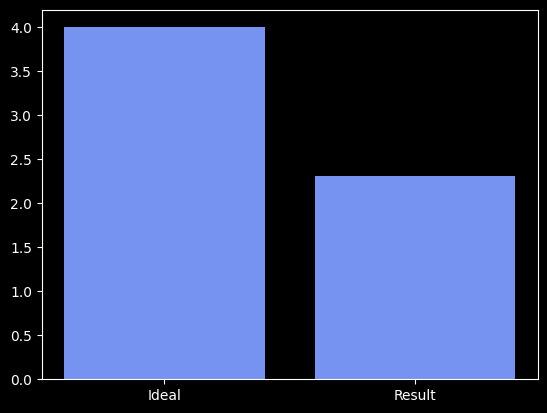

In [111]:
# from qiskit.visualization import plot_histogram

# import matplotlib.pyplot as plt
# plt.style.use('dark_background')

# data = {"Ideal": result_exact.values[0],"Result": result.values[0]}
# plt.bar(range(len(data)), data.values(), align='center', color = "#7793f2")
# plt.xticks(range(len(data)), list(data.keys()))

# plt.show()

## 2. Transpilation & Error Mitigation

Oftentimes, the quantum circuits constructed for utility scale algorithms are not well optimized to run on noisy quantum hardware.  In fact, it may even be important to post-process your results using error mitigation techniques.  Fortunately, there are a few ways to implement both error mitigation as well as optimizations of your quantum circuits.

The first is to simply set a few Runtime configuration options; specifically the `optimization_level` and `resilience_level`.  These are both managed and included in a Runtime Primitive using the `Options` object.

The options for `optimization_level` are:

| Optimization Level | Estimator & Sampler |
| :--- | :--- |
| 0 | No optimization: typically used for hardware characterization or debugging <br />    - Basis translation <br /> - Layout (`TrivialLayout`: virtual -> physical)  <br /> - Routing: `StochasticSwap` |
| 1, 2, 3 | Light optimization: (TODO: update this w/ current docs) <br /> - Layout (trivial → vf2 → SabreLayout if routing is required) <br /> - Routing (SabreSwap if needed) <br /> - 1Q gate optimization <br /> - Error suppression: dynamical decoupling |


And the options for `resilience_level` are different between the `Sampler` and `Estimator` primitives

| Resilience Level | Definition | Estimator | Sampler |
| :--- | :--- | :--- | :---
|0 | No mitigation	| None | None |
|1 [Default] |	Minimal mitigation costs: Mitigate error associated with readout errors | Twirled Readout Error eXtinction (TREX interpreted-text readout errors )	| M3 |
| 2 | Medium mitigation costs. Typically reduces bias in estimators, but is not guaranteed to be zero bias. | Zero Noise Extrapolation (ZNE interpreted-text) |	- |
| 3| Heavy mitigation with layer sampling. Theoretically expected to deliver zero bias estimators. | Probabilistic Error cancelation (PEC interpreted-text)	| - |


Let's look at a quick example

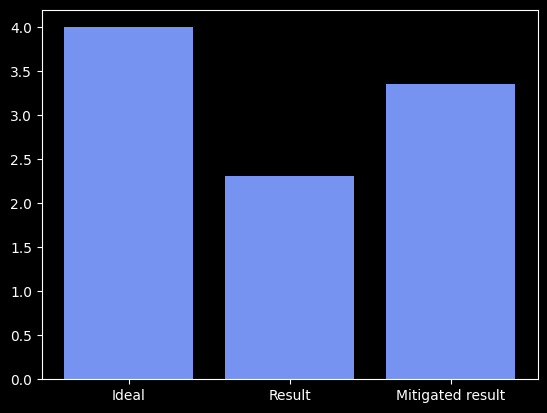

In [110]:
# from qiskit.visualization import plot_histogram

# import matplotlib.pyplot as plt
# plt.style.use('dark_background')

# data = {"Ideal": result_exact.values[0],"Result": result.values[0],"Mitigated result": result_mitigated.values[0]}
# plt.bar(range(len(data)), data.values(), align='center', color = "#7793f2")
# plt.xticks(range(len(data)), list(data.keys()))

# plt.show()

# Resources

If you'd like to learn more about the Qiskit SDK, the Qiskit ecosystem, or tutorials/how-to guides these links will help you along your way.

- Qiskit Documentation: https://docs.quantum.ibm.com/

- Qiskit Ecosystem: https://qiskit.github.io/ecosystem/

- IBM Quantum Learning Platform: https://learning.quantum.ibm.com/

## Optional: Configuring Runtime options

Oftentimes, the quantum circuits constructed for utility scale algorithms are not well optimized to run on noisy quantum hardware.  In fact, it may even be important to post-process your results using error mitigation techniques.  Fortunately, there are a few ways to implement both error mitigation as well as optimizations of your quantum circuits.

The first is to simply set a few Runtime configuration options; specifically the `resilience_level` option.  These are both managed and included in a Runtime Primitive using its `.options` attribute or with the `EstimatorOptions` or `SamplerOptions` objects.


And the options for `resilience_level` for the `Estimator` primitives will implement the following error mitigation techniques.

| Resilience Level | Definition | Estimator |
| :--- | :--- | :--- |
|0 | No mitigation	| None |
|1 [Default] |	Minimal mitigation costs: Mitigate error associated with readout errors | Twirled Readout Error eXtinction (TREX)<sup> [1](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.105.032620) </sup>	|
| 2 | Medium mitigation costs. Typically reduces bias in estimators, but is not guaranteed to be zero bias. | Level 1 + Zero Noise Extrapolation (ZNE)<sup>[3,](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509)[4](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.7.021050)</sup>  |	


Let's look at a quick example

In [34]:
from qiskit_ibm_runtime import EstimatorOptions, SamplerOptions

sampler_options = SamplerOptions()
estimator_options = EstimatorOptions()

In [36]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

estimator = Estimator()
estimator.options.resilience_level = 2
job = estimator.run([(transpiled_circuit, observables)])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Session ID: {job.session_id}")
print(f">>> Job Status: {job.status()}")

/home/kaelyn/.cache/pypoetry/virtualenvs/qiskit_1-0_scratch_space-fyWgEqUn-py3.11/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:853: UserWarning: The backend ibm_nazca currently has a status of internal.
  warnings.warn(


>>> Job ID: crkahfnybg1g0087bnc0
>>> Session ID: crkahfd4r70g0088s2eg
>>> Job Status: QUEUED


In [37]:
# Use a job id from a previous result
job = service.job("cqsj3ax88ev000810a5g")
print(f">>> Job Status: {job.status()}")

>>> Job Status: JobStatus.DONE


In [40]:
# Examine our results once the job has completed
result = job.result()
print(f">>> {result} \n \n", 32*"#", "\n")
print(f" >>  Expectation values:\n {result[0].data.evs} \n\n >> Standard Deviation: {result[0].data.stds}")
print('\n', 32*"#", '\n')
print(f" >>  Metadata:\n {result[0].metadata} \n\n")

>>> PrimitiveResult([PubResult(data=DataBin<>(evs=4.053811557552828, stds=0.05269990074501288), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {'twirled_readout_errors': [[0, 0.00927734375], [1, 0.02978515625]], 'zne_noise_factors': 0.0, 'zne_extrapolator': 'exponential'}, 'num_randomizations': 32})], metadata={'twirling': {'enable_gates': True, 'enable_measure': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'zne': {'noise_factors': [1.0, 3.0, 5.0], 'extrapolator': ['exponential', 'linear']}}, 'version': 2}) 
 
 ################################ 

 >>  Expectation values:
 4.053811557552828 

 >> Standard Deviation: 0.05269990074501288

 ################################ 

 >>  Metadata:
 {'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {'twirled_readout_errors': [[0, 0.00927734375], [1, 0.02978515625]], 'zne_noise_factors': 0.0, 'zne_extrapolator': 'ex

### Other Runtime Options

A quick note here: tuning the options for error mitigation are now quite granular with the V2 primitives, check the documentation pages for more information on using the [`EstimatorOptions`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.EstimatorOptions) and [`SamplerOptions`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.SamplerOptions) objects.

## Customizing transpilation

If the built-in transpilation offered by Qiskit Runtime is not sufficient for your purposes, you can customize transpilation yourself and submit transpiled circuits to the service. When doing so, make sure to set the `skip_transpilation=True` option in the primitive object you instantiate:

### Generate a preset staged pass manager

To create a preset staged pass manager with reasonable defaults, use the `generate_preset_pass_manager` function:

In [41]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)



The arguments to `generate_preset_pass_manager` match the arguments to the `transpile` function.

### Create your own pass manager

The `qiskit.transpiler.passes` module includes many transpiler passes that can be used to create pass managers. To create a pass manager, initialize a `PassManager` with a list of passes. For example, the following code creates a transpiler pass that merges adjacent two-qubit gates and then synthesizes them into a basis of $R_y$, $R_z$, and $R_{xx}$,  gates.

In [42]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    Collect2qBlocks,
    ConsolidateBlocks,
    UnitarySynthesis,
)

basis_gates = ["rx", "ry", "rxx"]
translate = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(basis_gates),
    ]
)

To demonstrate this pass manager in action, test it on a two-qubit circuit consisting of a Hadamard followed by two adjacent CX gates:

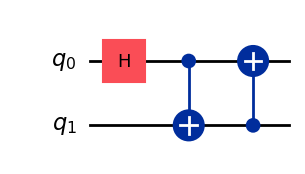

In [43]:
from qiskit import QuantumRegister, QuantumCircuit

qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)

a, b = qubits
circuit.h(a)
circuit.cx(a, b)
circuit.cx(b, a)

circuit.draw("mpl")

To run the pass manager on the circuit, call the `run` method.

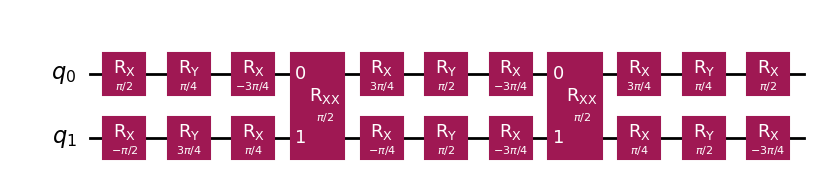

In [44]:
translated = translate.run(circuit)
translated.draw("mpl")

### Create a staged pass manager

A `StagedPassManager` is a pass manager that is composed of individual stages, where each stage is defined by a `PassManager` instance. You can create a `StagedPassManager` by specifying the desired stages. For example, the following code creates a staged pass manager with two stages, `init` and `translation`. The `translation` stage is defined by the pass manager that was created previously.

In [45]:
from qiskit.transpiler import PassManager, StagedPassManager
from qiskit.transpiler.passes import UnitarySynthesis, Unroll3qOrMore

basis_gates = ["rx", "ry", "rxx"]
init = PassManager(
    [
        UnitarySynthesis(basis_gates, min_qubits=3),
        Unroll3qOrMore(),
    ]
)
staged_pm = StagedPassManager(
    stages=["init", "translation"],
    init=init,
    translation=translate,
)

There is no limit on the number of stages you can put in a staged pass manager.

Another useful way to create a staged pass manager is to begin with a preset staged pass manager and then swap out some of the stages. For example, the following code generates a preset pass manager with optimization level 3, and then specifies a custom `pre_layout` stage.

In [46]:
import numpy as np
from qiskit.circuit.library import HGate, PhaseGate, RXGate, TdgGate, TGate
from qiskit.transpiler.passes import CXCancellation, InverseCancellation

pass_manager = generate_preset_pass_manager(3, backend)
inverse_gate_list = [
    HGate(),
    (RXGate(np.pi / 4), RXGate(-np.pi / 4)),
    (PhaseGate(np.pi / 4), PhaseGate(-np.pi / 4)),
    (TGate(), TdgGate()),
]
logical_opt = PassManager(
    [
        CXCancellation(),
        InverseCancellation(inverse_gate_list),
    ]
)

# Add pre-layout stage to run extra logical optimization
pass_manager.pre_layout = logical_opt

## Transpilation stages

Qiskit's prebuilt transpilation pipeline consists of six stages:

1. `init`
2. `layout`
3. `routing`
4. `translation`
5. `optimization`
6. `scheduling`

### Init stage

This first stage does very little by default and is primarily useful if you want to include your own initial optimizations.  Because most layout and routing algorithms are only designed to work with single- and two-qubit gates, this stage is also used to translate any gates that operate on more than two qubits into gates that only operate on one or two qubits.

### Layout stage
In the next stage, we start considering the layout or connectivity of the backend a circuit will be sent to.  In general, quantum circuits are abstract entities whose qubits are "virtual" or "logical" representations of actual qubits used in computations.  To execute a sequence of gates, a one-to-one mapping from the "virtual" qubits to the "physical" qubits in an actual quantum device is necessary.  This mapping is stored as a `Layout` object.


The choice of mapping is extremely important for minimizing the number of SWAP operations needed to map the input circuit onto the device topology and ensure the most well-calibrated qubits are used.  Due to the importance of this stage, the preset pass managers try a few different methods to find the best layout.  Typically this involves two steps: first, try to find a "perfect" layout (a layout that does not require any SWAP operations), and then, a heuristic pass that tries to find the best layout to use if a perfect layout cannot be found.  There are two `Passes` typically used for this first step:

- `TrivialLayout`: Naively maps each virtual qubit to the same numbered physical qubit on the device (i.e. [`0`,`1`,`1`,`3`] -> [`0`,`1`,`1`,`3`]).  This is historical behavior only used in `optimzation_level=1` to try to find a perfect layout.  If it fails, `VF2Layout` is tried next.
- `VF2Layout`: This is an `AnalysisPass` that selects an ideal layout by treating this stage as a subgraph isomorphism problem, solved by the VF2++ algorithm.  If more than one layout is found, a scoring heuristic is run to select the mapping with the lowest average error.

Then for the heuristic stage, two passes are used by default:

- `SabreLayout`: This pass selects a layout by starting from an initial random layout and repeatedly running the `SabreSwap` algorithm.  This pass is only used in optimization levels 1, 2, and 3 if a perfect layout isn't found via the `VF2Layout` pass.  For more details on this algorithm, refer to the paper: [arXiv:1809.02573](https://arxiv.org/abs/1809.02573)
- `DenseLayout`: Finds the sub-graph of the device with the greatest connectivity and that has the same number of qubits as the circuit.  (Used for optimization level 1 if there are control flow operations (such as IfElseOp) present in the circuit).


### Routing stage

In order to implement a two-qubit gate between qubits that are not directly connected on a quantum device, one or more SWAP gates must be inserted into the circuit to move the qubit states around until they are adjacent on the device gate map.  Each SWAP gate represents an expensive and noisy operation to perform.  Thus, finding the minimum number of SWAP gates needed to map a circuit onto a given device is an important step in the whole transpilation process.  For efficiency, this stage is typically computed alongside the Layout stage by default, but they are logically distinct from one another.  The *Layout* stage selects the hardware qubits to be used, while the *Routing* stage inserts the appropriate amount of SWAP gates in order to execute the circuits using the selected layout.  It's also important to point out here that the `SabreSwap` algorithm is different from the larger `SabreLayout` method in the previous stage.  By default, `SabreLayout` runs both layout and routing, and returns the transformed circuit.  This is done for a few particular technical reasons specified in the pass's [API reference page](../api/qiskit/qiskit.transpiler.passes.SabreLayout). 

However, finding the optimal SWAP mapping is hard. In fact, it is an NP-hard problem, and is thus prohibitively expensive to compute for all but the smallest quantum devices and input circuits. To work around this, Qiskit uses a stochastic heuristic algorithm called SabreSwap to compute a good, but not necessarily optimal, SWAP mapping. The use of a stochastic method means that the circuits generated are not guaranteed to be the same over repeated runs. Indeed, running the same circuit repeatedly results in a distribution of circuit depths and gate counts at the output. It is for this reason that many users choose to run the routing function (or the entire StagedPassManager) many times and select the lowest-depth circuits from the distribution of outputs.



As an example to demonstrate this, consider the following GHZ circuit which we will assign a "bad" layout to and run the `SabreSwap` routing algorithm 100 times.

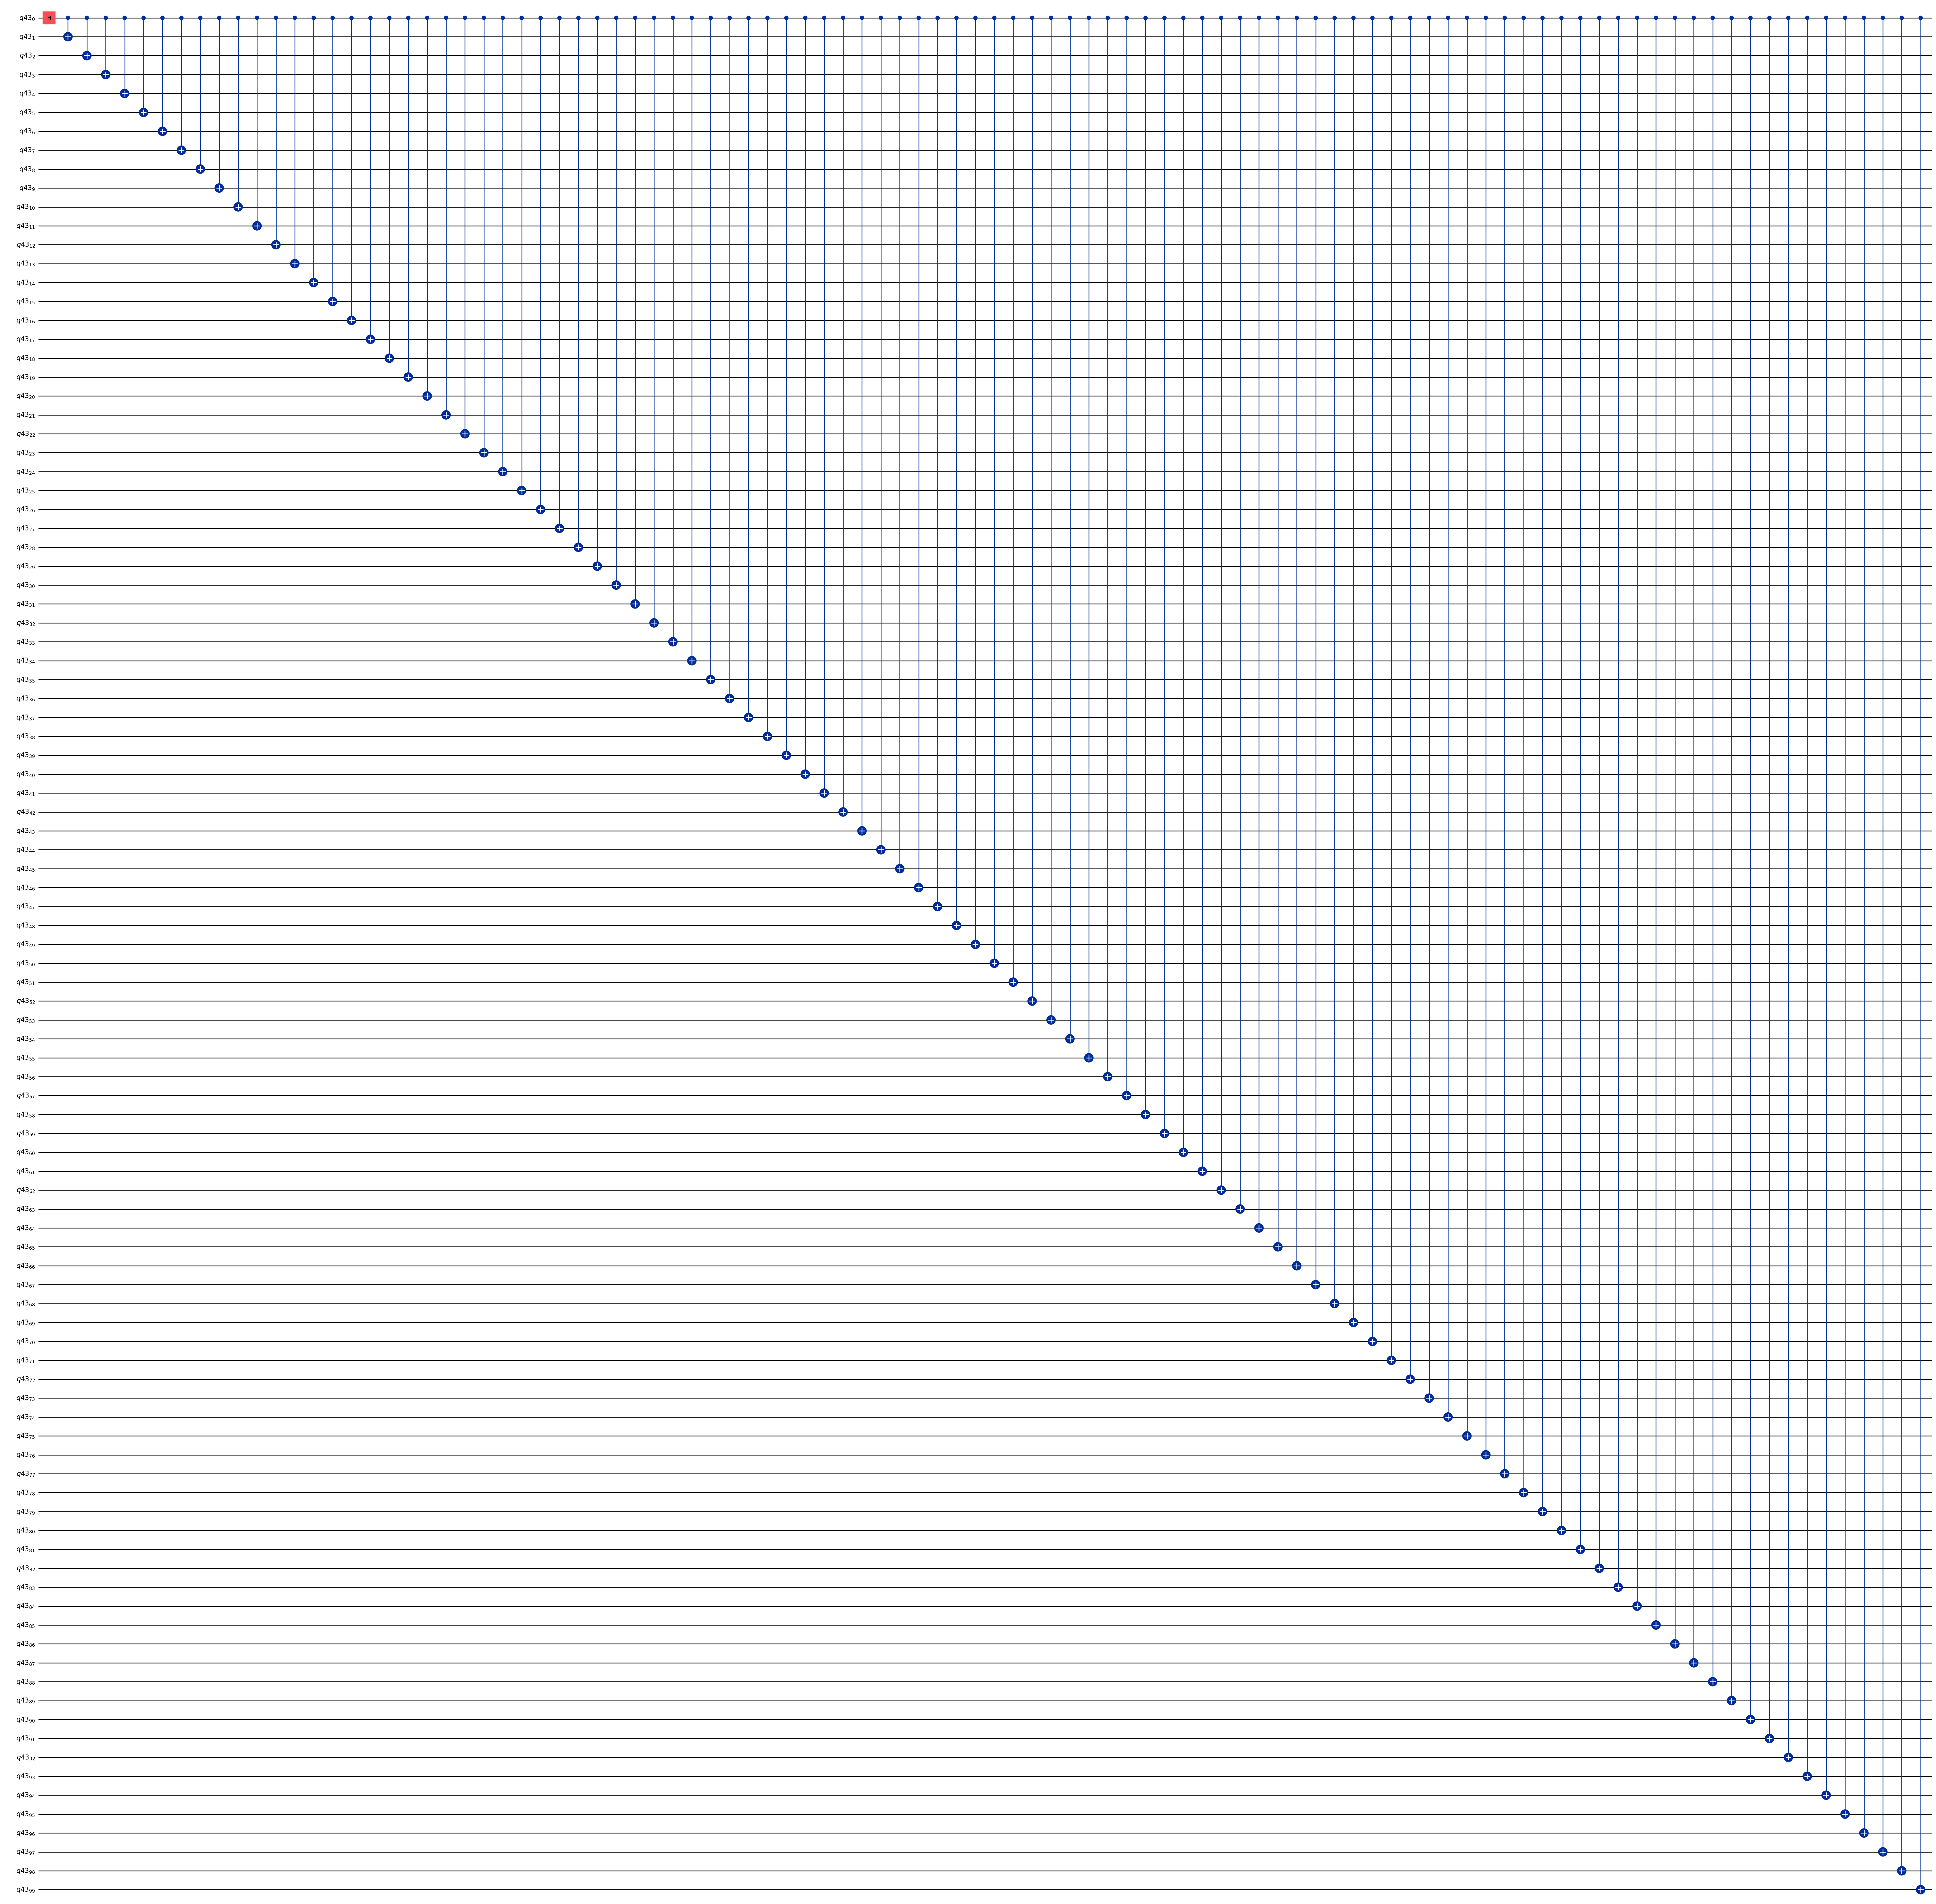

In [47]:
import matplotlib.pyplot as plt

qubits = QuantumRegister(100)
ghz = QuantumCircuit(qubits)
ghz.h(qubits[0])
ghz.cx(qubits[0], qubits[1:])

ghz.draw("mpl", fold=False)

Text(0, 0.5, 'Count')

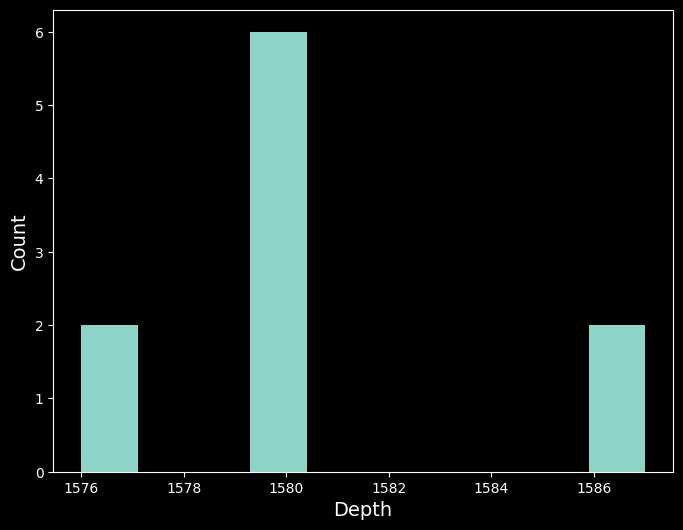

In [48]:
pass_manager = generate_preset_pass_manager(
    optimization_level=1,
    backend=backend,
    layout_method="trivial",  # Fixed layout mapped in circuit order
)
depths = []
for _ in range(10):
    depths.append(pass_manager.run(ghz).depth())

plt.figure(figsize=(8, 6))
plt.hist(depths)
plt.xlabel("Depth", fontsize=14)
plt.ylabel("Count", fontsize=14)

As you can see, this distribution is quite wide which demonstrates the difficulty the SWAP mapper is having in computing the best layout.  In general, it is good practice to run this algorithm many times and select the circuit with the lowest depth.

### Translation stage

Next is the translation stage.  In general when writing a quantum circuit, you are free to use any quantum gate (unitary operation) that you like, along with a collection of non-gate operations such as qubit measurement or reset instructions.  However, most quantum devices only natively support a handful of quantum gate and non-gate operations. This stage of the preset `PassManagers`  translates (or *unrolls*) the gates specified in a circuit to the native basis gates of a specified backend.  This is an important step, as it allows the circuit to be executed by the backend, but typically leads to an increase in the depth and number of gates.

There two special cases which are especially important to highlight, and which help illustrate what this stage does:

1. If a SWAP gate is not a native gate to the target backend, this requires three CNOT gates:

['ecr', 'id', 'delay', 'measure', 'reset', 'rz', 'sx', 'x', 'if_else', 'for_loop', 'switch_case']


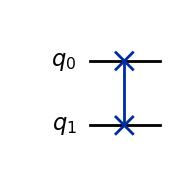

In [49]:
print(backend.configuration().supported_instructions)
circuit = QuantumCircuit(2)
circuit.swap(0, 1)
circuit.draw("mpl")

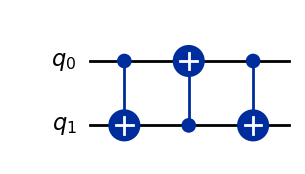

In [50]:
circuit.decompose().draw("mpl")

As a product of three CNOT gates, SWAPs are expensive operations to perform on noisy quantum devices.  However, such operations are usually necessary for embedding a circuit into the limited gate connectivities of many devices.  Thus, minimizing the number of SWAP gates in a circuit is a primary goal in the process of transpilation.

2. A Toffoli, or controlled-controlled-not gate (`ccx`), is a three-qubit gate.  Given that our basis gate set includes only single- and two-qubit gates, this operation must be decomposed.  However, it is quite costly:

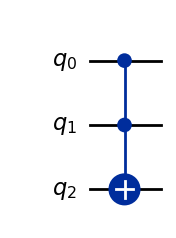

In [51]:
circuit = QuantumCircuit(3)
circuit.ccx(0, 1, 2)
circuit.draw("mpl")

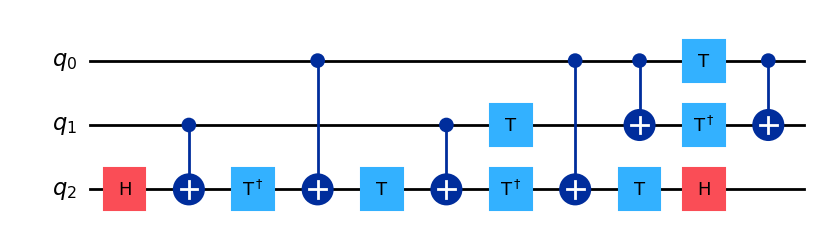

In [52]:
circuit.decompose().draw("mpl")

For every Toffoli gate in a quantum circuit, the hardware may execute up to six CNOT gates and a handful of single-qubit gates.  From this example, it should be clear that any algorithm that makes use of multiple Toffoli gates will end up as a circuit with large depth and will therefore be appreciably affected by noise.

### Optimization stage

This stage centers around decomposing quantum circuits into the basis gate set of the target device, and must fight against the increased depth from the layout and routing stages.  Fortunately, there are many routines for optimizing circuits by either combining or eliminating gates.  In some cases, these methods are so effective that the output circuits have lower depth than the inputs, even after layout and routing to the hardware topology.  In other cases, not much can be done, and the computation may be difficult to perform on noisy devices.  This stage is where the various optimization levels begin to differ.

- For `optimization_level=1`, this stage prepares the [`Optimize1qGatesDecomposition`](../api/qiskit/qiskit.transpiler.passes.Optimize1qGatesDecomposition) and [`CXCancellation`](../api/qiskit/qiskit.transpiler.passes.CXCancellation), which combine chains of single-qubit gates and cancel any back-to-back CNOT gates.
- For `optimization_level=2`, this stage uses the [`CommutativeCancellation`](../api/qiskit/qiskit.transpiler.passes.CommutativeCancellation) pass instead of `CXCancellation`, which removes redundant gates by exploiting commutation relations.
- For `optimization_level=3`, this stage prepares the following passes:
  - [`Collect2qBlocks`](../api/qiskit/qiskit.transpiler.passes.Collect2qBlocks)
  - [`ConsolidateBlocks`](../api/qiskit/qiskit.transpiler.passes.ConsolidateBlocks)
  - [`UnitarySynthesis`](../api/qiskit/qiskit.transpiler.passes.UnitarySynthesis)
  - [`Optimize1qGateDecomposition`](../api/qiskit/qiskit.transpiler.passes.Optimize1qGatesDecomposition)
  - [`CommutativeCancellation`](../api/qiskit/qiskit.transpiler.passes.CommutativeCancellation)


Additionally, this stage also executes a few final checks to make sure that all instructions in the circuit are composed of the basis gates available on the target backend.


To demonstrate, the following code constructs a 15-qubit GHZ state and compares the various `optimization_levels` of transpilation in terms of the resulting circuit depth, gate counts, and multi-qubit gate counts.

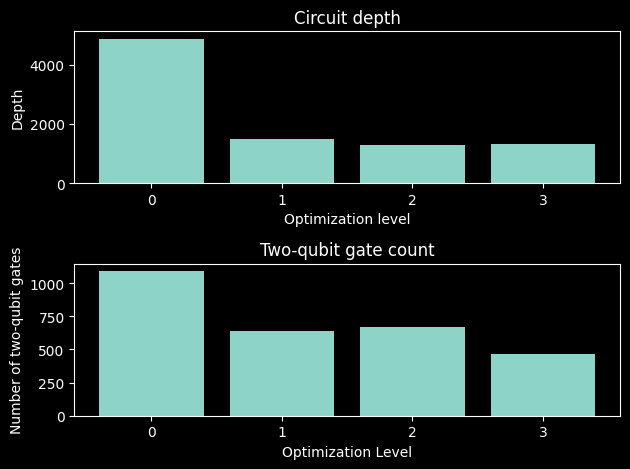

In [53]:
depths = []
gate_counts = []
multiqubit_gate_counts = []
levels = [str(x) for x in range(4)]
for level in range(4):
    pass_manager = generate_preset_pass_manager(
        optimization_level=level,
        backend=backend,
    )
    circuit = pass_manager.run(ghz)
    depths.append(circuit.depth())
    multiqubit_gate_counts.append(circuit.count_ops()["ecr"])

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.bar(levels, depths, label="Depth")
ax1.set_xlabel("Optimization level")
ax1.set_ylabel("Depth")
ax1.set_title("Circuit depth")
ax2.bar(levels, multiqubit_gate_counts)
ax2.set_xlabel("Optimization Level")
ax2.set_ylabel("Number of two-qubit gates")
ax2.set_title("Two-qubit gate count")
fig.tight_layout()
plt.show()

### Scheduling

This last stage is only run if it is explicitly called for (similar to the `Init` stage) and does not run by default (though a method can be specified by setting the scheduling_method argument when calling generate_preset_pass_manager). The scheduling stage is typically used once the circuit has been translated to the target basis, mapped to the device, and optimized. These passes focus on accounting for all the idle time in a circuit. At a high level, the scheduling pass can be thought of as explicitly inserting delay instructions to account for the idle time between gate executions and to inspect how long the circuit will be running on the backend.
